## Project: Decision Tracker
## Making informed decisions based on personal data
**Source:** Own files

### 1. Setting up environment

#### 1.1 Importing packages & setting-up parameters

In [1]:
# Import parent directory (main project directory)
# for packages importing
import sys
import os

# Getting the parent directory name in which your script is running
parent = os.path.dirname(os.path.realpath('/'))

# adding the parent directory to
# the sys.path.
sys.path.append(parent)

# now we can import the module in the parent
# directory.

In [2]:
import requests # to download data from api
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pathlib # for path functions
import numpy as np

import sqlite3
import seaborn as sns
import ipywidgets as widgets
from IPython.display import clear_output, display

#turning on plot display in JN
%matplotlib inline 
# Setting pandas display options
pd.options.display.max_columns = 300
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 250

In [3]:
# PARAMETERS
plt.style.use('fivethirtyeight')

In [ ]:
DataFolderPath = pathlib.Path(os.path.dirname(os.path.realpath(''))).parent
print(DataFolderPath)

In [ ]:
#CLASSES

In [ ]:
def import_bills(filename, sheet_name):
    # Necessary requirements - DataFolderPath
    file = os.path.join(DataFolderPath, 'Private', filename)
    data_in = pd.read_excel(file, sheet_name = sheet_name , decimal=',')
    data_out = data_in
    data_out["LP"] = data_in["LP"].astype(np.int32)
    data_out["Rok"] = data_in["Rok"].astype(np.int32)
    data_out["Miesiac"] = data_in["Miesiac"].astype(np.int32)
    data_out["Data"] = pd.to_datetime(data_in["Data"])
    data_out["Cena"] = data_in["Cena"].replace(',','.').astype(float)
    if "Nr koszyka" in data_in.columns:
        data_out["Nr koszyka"] = data_in["Nr koszyka"].astype(str)

    # Cleaning data
    data_out = data_out[data_out["Rok"] != 1900].copy() # usuwanie wierszy bez dat
    data_out = data_out[data_out["Kategoria"].notna()].copy()

    def clean_category(category):
        return category.lower().strip()

    # Oczyszczanie nazw kategorii
    data_out['Kategoria'] = data_out['Kategoria'].apply(clean_category)

    print(data_out.tail()) # sample check
    return data_out



In [ ]:
def sql_sum(data_in):
    # 2. Stworzenie lokalnej bazy danych SQLite
    conn = sqlite3.connect('transactions_db.sqlite')
    data_in.to_sql('transactions', conn, if_exists='replace', index=False)
    conn.commit()

    # Przygotowanie agregacji danych
    query_sum = "SELECT Rok, Miesiac, Rodzaj, Kategoria, SUM(Cena) AS Suma FROM transactions GROUP BY Rok, Miesiac, Kategoria, Rodzaj"
    data_out = pd.read_sql(query_sum, conn)
    print(data_out.tail())
    return data_out

In [ ]:
class WidgetBarPlot():
    def __init__(self, data_in):
        self.data_in = data_in
        self._data_filters()
    
    def _data_filters(self):
        self._years = sorted(self.data_in['Rok'].unique())
        self._months = sorted(self.data_in['Miesiac'].unique())
        self._rodzaje = sorted(self.data_in['Rodzaj'].unique())

        self.default_year = max(self._years )
        self.default_rodzaj = "Debit"
        self.default_month = max(self.data_in[self.data_in['Rok'] == self.default_year]["Miesiac"])

    def _barplot(self, years, months, rodzaje):
        # Filtrujemy dane według wybranych lat, miesięcy i rodzajów transakcji
        data = self.data_in[
            self.data_in['Rok'].isin(years) & 
            self.data_in['Miesiac'].isin(months) & 
            self.data_in['Rodzaj'].isin(rodzaje)
        ].sort_values('Suma')
        
        plt.figure(figsize=(10, 8))
        ax = sns.barplot(data=data, x='Miesiac', y='Suma', hue='Kategoria', order=data['Miesiac'].unique())
        
        # Dodajemy etykiety do słupków
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.0f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height() - p.get_height()/10), 
                        ha='center', va='center', 
                        xytext=(0, -10), 
                        textcoords='offset points')
        
        plt.title('Miesięczne wpływy/koszty w podziale na kategorie')
        
        # Przenoszenie legendy pod wykres
        ax.legend(title='Kategoria', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)
        
        plt.tight_layout()
        plt.show()

    def widget_plot(self):
        # Uaktualnienie widgetu z wielokrotnym wyborem wartości
        widgets.interact(
            self._barplot, 
            years=widgets.SelectMultiple(options=self._years, description='Rok:', value=(self.default_year,)), 
            months=widgets.SelectMultiple(options=self._months, description='Miesiąc:', value=(self.default_month,)),
            rodzaje=widgets.SelectMultiple(options=self._rodzaje, description='Rodzaj:', value=(self.default_rodzaj,))
        )



In [ ]:
class WidgetBarPlot_lastNMonths():
    def __init__(self, data_in):
        self.data_in = data_in
        self._data_params()
    
    def _data_params(self):
        self._categories = sorted(list(set(self.data_in['Kategoria'].unique())))
        self._types = sorted(list(set(self.data_in['Rodzaj'].unique())))
        self._rodzaj = ("Debit",)

        # Znalezienie najdłuższej kategorii
        self._max_length = max(self._categories, key=len)

    def _barplot_lastn(self, categories, last_n_months, rodzaj):
        # Pobieranie najnowszej dostępnej daty
        latest_year = max(self.data_in['Rok'])
        latest_month = max(self.data_in[self.data_in['Rok'] == latest_year]["Miesiac"])
        
        # Określenie zakresu daty na podstawie last_n_months
        end_month = latest_month
        end_year = latest_year
        
        start_month = latest_month - last_n_months + 1
        start_year = latest_year
        while start_month <= 0:
            start_month += 12
            start_year -= 1

        # Filtrujemy dane według wybranego zakresu czasu, rodzaju i kategorii
        filtered_data = self.data_in[
            ((self.data_in['Rok'] > start_year) | 
            ((self.data_in['Rok'] == start_year) & (self.data_in['Miesiac'] >= start_month)) &
            ((self.data_in['Rok'] < end_year) |
            ((self.data_in['Rok'] == end_year) & (self.data_in['Miesiac'] <= end_month)))) &
            (self.data_in['Rodzaj'].isin(rodzaj)) &
            (self.data_in['Kategoria'].isin(categories))
        ]

        # Sumowanie danych dla wybranych kategorii
        summed_data = filtered_data.groupby(['Rok', 'Miesiac']).agg({'Suma': 'sum'}).reset_index()
        
        # Dodawanie kolumny "rok-miesiąc" do summed_data
        summed_data['Rok-Miesiac'] = summed_data['Rok'].astype(str) + "-" + summed_data['Miesiac'].astype(str).str.zfill(2)
        
        plt.figure(figsize=(15, 8))
        
        # Tworzenie wykresu słupkowego
        ax = sns.barplot(data=summed_data, x='Rok-Miesiac', y='Suma')
        
        # Dodawanie etykiet do słupków
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.0f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height() - p.get_height()/10), 
                        ha='center', va='center', 
                        xytext=(0, -10), 
                        textcoords='offset points')
        
        plt.title('Miesięczne wpływy/koszty w podziale na kategorie')
        plt.tight_layout()
        
        plt.show()


    def widget_plot(self):
    # Uruchamiam interaktywną wizualizację
        widgets.interact(
            self._barplot_lastn, 
            categories=widgets.SelectMultiple(
                options=self._categories, 
                description='Kategoria:', 
                layout=widgets.Layout(width=f'{len(self._max_length) * 8 + 20}px', height=f'{int(len(self._categories)*25*0.85)}px'),
                value=self._categories  # Domyślnie zaznacz wszystkie kategorie
            ),
            last_n_months=widgets.Dropdown(options=[3, 6, 9, 12, 18, 24], description='Ostatnie miesiące:', value=6),
            rodzaj=widgets.SelectMultiple(options=self._types, description='Rodzaj:', value=self._rodzaj)
        )


In [ ]:
class PivotTimeRange():
    def __init__(self, data_in):
        self.data_in = data_in
        self._data_filters()
        self._widgets()
    
    def _data_filters(self):
        self.data_in['Rok-Miesiac'] = self.data_in['Rok'].astype(str) + '-' + self.data_in['Miesiac'].astype(str).str.zfill(2)
        
        # Ustalanie indeksów dla najnowszego roku w danych
        self.current_year = self.data_in['Rok'].max()
        self.start_idx = self.data_in[self.data_in['Rok'] == self.current_year]['Rok-Miesiac'].min()
        self.end_idx = self.data_in[self.data_in['Rok'] == self.current_year]['Rok-Miesiac'].max()


    def _widgets(self):
        # Widgety
        self.date_range = widgets.SelectionRangeSlider(
            options=sorted(self.data_in['Rok-Miesiac'].unique()),
            index=(self.data_in['Rok-Miesiac'].unique().tolist().index(self.start_idx), 
                self.data_in['Rok-Miesiac'].unique().tolist().index(self.end_idx)),
            description='Zakres dat:',
            continuous_update=False,
            layout=widgets.Layout(width='500px')
        )

        self.category_selector = widgets.SelectMultiple(
            options=sorted(self.data_in['Kategoria'].unique()),
            value=list(self.data_in['Kategoria'].unique()),
            description='Kategoria:',
            continuous_update=False,
            rows=len(self.data_in['Kategoria'].unique()),
            layout=widgets.Layout(width='1000px')
        )

        self.type_selector = widgets.SelectMultiple(
            options=sorted(self.data_in['Rodzaj'].unique()),
            value=['Debit'],
            description='Rodzaj:',
            continuous_update=False,
            rows=len(self.data_in['Rodzaj'].unique())
        )
        self.output = widgets.Output()

    def _update_table(self, change=None):
        with self.output:
            clear_output(wait=True)
            filtered_data = self.data_in[
                (self.data_in['Rok-Miesiac'] >= self.date_range.value[0]) &
                (self.data_in['Rok-Miesiac'] <= self.date_range.value[1]) &
                (self.data_in['Kategoria'].isin(self.category_selector.value)) &
                (self.data_in['Rodzaj'].isin(self.type_selector.value))
            ]
            pivot = filtered_data.pivot_table(index='Kategoria', columns='Rok-Miesiac', values='Suma', aggfunc='sum').fillna(0).sort_index()
            
            # Zaokrąglenie do 2 miejsc po przecinku
            pivot = pivot.round(2)
            
            # Dodanie kolumny "Sum_total"
            pivot['Sum_total'] = pivot.sum(axis=1)
            
            # Dodanie wiersza "TOTAL"
            pivot.loc['TOTAL'] = pivot.sum()
            
            display(pivot)

    def pivot_calc(self):
        self.date_range.observe(self._update_table, names='value')
        self.category_selector.observe(self._update_table, names='value')
        self.type_selector.observe(self._update_table, names='value')

        display_widgets = widgets.VBox([self.date_range, self.category_selector, self.type_selector, self.output])
        display(display_widgets)
        self._update_table()

In [5]:
# filename = 'Wydatki_2021.xlsx'
# file = os.path.join(DataFolderPath, 'Private', filename)

In [6]:
# Unused SQL Queries - move to beggining


# 3. Przygotowanie agregacji danych
# Miesięczne wpływy
# query_monthly_income = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wplywy FROM transactions WHERE Rodzaj = 'Credit' GROUP BY Rok, Miesiac, Kategoria"
# monthly_income_by_type = pd.read_sql(query_monthly_income, conn)

# Miesięczne wydatki
# query_monthly_expenses = "SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki FROM transactions WHERE Rodzaj = 'Debit' GROUP BY Rok, Miesiac, Kategoria"
# monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Miesięczne przepływy
# query_monthly_flow = "SELECT Rok, Miesiac, SUM(Case When Rodzaj = 'Credit' THEN Cena ELSE 0 END) as Wplywy, SUM(Case When Rodzaj = 'Debit' THEN Cena ELSE 0 END) as Wydatki FROM transactions GROUP BY Rok, Miesiac"
# monthly_flow = pd.read_sql(query_monthly_flow, conn)
# monthly_flow["Przeplywy"] = monthly_flow["Wplywy"] + monthly_flow["Wydatki"]

# Analiza miesięcznej struktury wydatków
# monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# 4. Przygotowanie danych kumulatywnych
# Kumulacyjne wpływy
# monthly_income_by_type['Kumulacyjne_Wplywy'] = monthly_income_by_type.groupby(['Rok', 'Kategoria'])['Wplywy'].cumsum()

# Kumulacyjne wydatki
# monthly_expenses_by_type['Kumulacyjne_Wydatki'] = monthly_expenses_by_type.groupby(['Rok', 'Kategoria'])['Wydatki'].cumsum()

# Kumulacyjne przepływy
# monthly_flow['Kumulacyjne_Wplywy'] = monthly_flow.groupby('Rok')['Wplywy'].cumsum()
# monthly_flow['Kumulacyjne_Wydatki'] = monthly_flow.groupby('Rok')['Wydatki'].cumsum()
# monthly_flow['Kumulacyjne_Przeplywy'] = monthly_flow['Kumulacyjne_Wplywy'] + monthly_flow['Kumulacyjne_Wydatki']

# Kumulacyjna analiza struktury wydatków
# cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Kumulacyjne_Wydatki'].sum().reset_index()
# cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Kumulacyjne_Wydatki': 'Suma_Kumulacyjnych_Wydatkow'})
# cumulative_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
# cumulative_expenses_structure['Procent_Kumulacyjny'] = cumulative_expenses_structure['Kumulacyjne_Wydatki'] / cumulative_expenses_structure['Suma_Kumulacyjnych_Wydatkow'] 


In [8]:
wydatki = import_bills(filename = 'Wydatki_2021.xlsx', sheet_name = 'Wydatki')

        LP       Data                           Przedmiot    Cena Waluta  \
4828  4762 2023-09-24                          Ashwaganda -134.10    PLN   
4829  4763 2023-09-24         Babbel - roczna subskrypcja -239.88    PLN   
4830  4764 2023-09-24  Diagnostyka - panel alergologiczny -221.08    PLN   
4831  4765 2023-09-24                            Kreatyna  -99.00    PLN   
4832  4766 2023-09-24                  Aliness suplementy -153.33    PLN   

                   Sklep                  Miejsce Nr koszyka            Skad  \
4828  mothersprotect.com  othersprotect.com (WWW)     3734.0  Citi Kredytowa   
4829       pl.babbel.com      pl.babbel.com (WWW)     3735.0  Citi Kredytowa   
4830      diagnostyka.pl     diagnostyka.pl (WWW)     3736.0  Citi Kredytowa   
4831           beketo.pl          beketo.pl (WWW)     3737.0  Citi Kredytowa   
4832          aliness.pl         aliness.pl (WWW)     3738.0   Alior Firmowa   

        Potrzeba                       Kategoria      Grupa   

c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [9]:
wydatki_wspolne = import_bills(filename = 'Wydatki_2021.xlsx', sheet_name = 'Wydatki_KontoWspolne')

        LP       Data  \
1208  1209 2023-09-23   
1209  1210 2023-09-24   
1210  1211 2023-09-24   
1211  1212 2023-09-24   
1212  1213 2023-09-24   

                                                                            Przedmiot  \
1208                                                 Maciej - przelew za zdrową Krowę   
1209                                Dieta KETO, 2500 kcal, 21 dni, BonApetit Catering   
1210                                           Maszyna do robienia popcornu bez oleju   
1211  Temu.com - krajalnica do ziemniaków, wyciskarka do czosnku, obieraczka do jajek   
1212                                                                      Office 2021   

         Cena Waluta               Sklep    Kto    Potrzeba  \
1208  -340.60    PLN        Zdrowa Krowa  Tomek  Zachcianka   
1209 -2034.90    PLN           Dietly.pl  Tomek    Potrzeba   
1210   -82.98    PLN        Media Expert  Tomek  Zachcianka   
1211   -40.65    PLN            temu.com  Tomek  Zachcianka   

c:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:81: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [11]:
monthly_wydatki = sql_sum(wydatki)

       Rok  Miesiac  Rodzaj                       Kategoria     Suma
1038  2023        9   Debit                      suplementy  -723.43
1039  2023        9   Debit                       transport   -20.40
1040  2023        9   Debit          wspólny rachunek - ada -9565.23
1041  2023        9  Credit  własny rozwój (kursy, zajęcia)  1063.98
1042  2023        9   Debit  własny rozwój (kursy, zajęcia) -4975.33


In [12]:
monthly_wspolne = sql_sum(wydatki_wspolne)

      Rok  Miesiac Rodzaj                       Kategoria    Suma
276  2023        9  Debit         rozrywka i przyjemności -618.99
277  2023        9  Debit                       szastusia -243.17
278  2023        9  Debit                            taxi -168.83
279  2023        9  Debit                       transport  -17.00
280  2023        9  Debit  własny rozwój (kursy, zajęcia)  -40.00


In [15]:
# https://www.google.com/search?client=firefox-b-d&q=vs+code+interactive+plots+in+python#ip=1

In [18]:
wydatki_barplot = WidgetBarPlot(data_in = monthly_wydatki)
wydatki_barplot.widget_plot()

interactive(children=(SelectMultiple(description='Rok:', index=(4,), options=(2019, 2020, 2021, 2022, 2023), v…

In [19]:
wspolne_barplot = WidgetBarPlot(data_in = monthly_wspolne)
wspolne_barplot.widget_plot()

interactive(children=(SelectMultiple(description='Rok:', index=(1,), options=(2022, 2023), value=(2023,)), Sel…

In [21]:
wydatki_lastN = WidgetBarPlot_lastNMonths(data_in = monthly_wydatki)
wydatki_lastN.widget_plot()

interactive(children=(SelectMultiple(description='Kategoria:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

In [22]:
wspolne_lastN = WidgetBarPlot_lastNMonths(data_in = monthly_wspolne)
wspolne_lastN.widget_plot()

interactive(children=(SelectMultiple(description='Kategoria:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12…

In [26]:
wydatki_pivot = PivotTimeRange(data_in = monthly_wydatki)
wydatki_pivot.pivot_calc()

In [27]:
wspolne_pivot = PivotTimeRange(data_in = monthly_wspolne)
wspolne_pivot.pivot_calc()

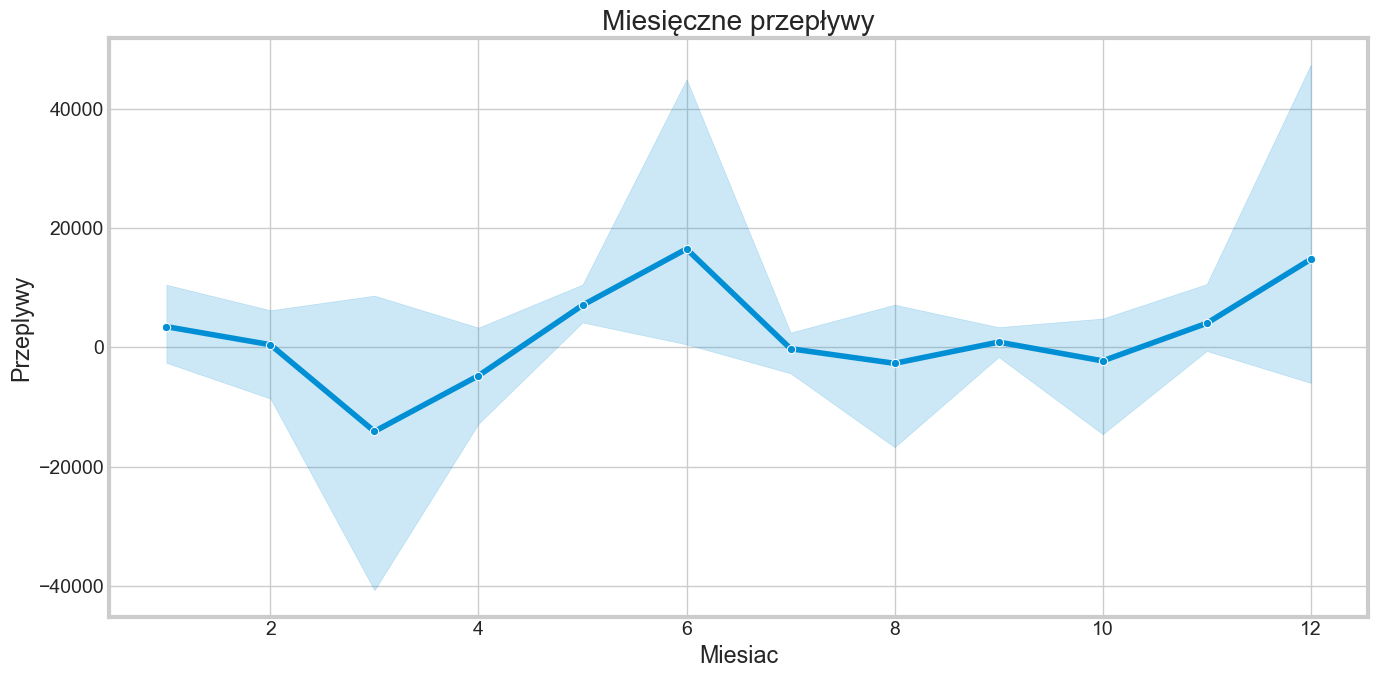

In [ ]:
# Wykres miesięcznych przepływów
plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_flow, x='Miesiac', y='Przeplywy', marker="o")
plt.title('Miesięczne przepływy')
plt.tight_layout()
plt.show()


In [ ]:
# Stworzenie lokalnej bazy danych SQLite
conn = sqlite3.connect('transactions_db_temp.sqlite')
df.to_sql('transactions', conn, if_exists='replace', index=False)

# Przygotowanie agregacji danych
query_monthly_expenses = """
SELECT Rok, Miesiac, Kategoria, SUM(Cena) AS Wydatki 
FROM transactions WHERE Rodzaj = 'Debit' 
GROUP BY Rok, Miesiac, Kategoria
"""

monthly_expenses_by_type = pd.read_sql(query_monthly_expenses, conn)

# Poprawione obliczenie procentowego udziału kategorii w miesięcznych wydatkach
monthly_expenses_by_type['Procent'] = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].transform(lambda x: x / x.sum() * 100)

# Tworzenie monthly_expenses_structure
cumulative_expenses_sum = monthly_expenses_by_type.groupby(['Rok', 'Miesiac'])['Wydatki'].sum().reset_index()
cumulative_expenses_sum = cumulative_expenses_sum.rename(columns={'Wydatki': 'Suma_Wydatkow'})
monthly_expenses_structure = pd.merge(monthly_expenses_by_type, cumulative_expenses_sum, on=['Rok', 'Miesiac'])
monthly_expenses_structure['Procent_Struktury'] = monthly_expenses_structure['Wydatki'] / monthly_expenses_structure['Suma_Wydatkow'] * 100

monthly_expenses_structure.head(10)

,Rok,Miesiac,Kategoria,Wydatki,Procent,Suma_Wydatkow,Procent_Struktury
0,2019,11,alkohol,-120.86,9.804256,-1232.73,9.804256
1,2019,11,czynsz za mieszkanie,-517.74,41.999465,-1232.73,41.999465
2,2019,11,dowolne zakupy,-0.45,0.036504,-1232.73,0.036504
3,2019,11,"higiena, kosmetyki, fryzjer",-6.99,0.567034,-1232.73,0.567034
4,2019,11,"hobby, kino, teatr",-29.70,2.409287,-1232.73,2.409287
5,2019,11,jedzenie i picie,-185.25,15.027622,-1232.73,15.027622
6,2019,11,jedzenie i picie: na mieście,-182.33,14.790749,-1232.73,14.790749
7,2019,11,jedzenie i picie: niezdrowe,-16.57,1.344171,-1232.73,1.344171
8,2019,11,jedzenie i picie: zamawiane,-139.86,11.345550,-1232.73,11.345550
9,2019,11,pomoc innym,-24.37,1.976913,-1232.73,1.976913
